THIS CODE IS FOR VISUALIZING THE BO ITERATIONS IN 2D

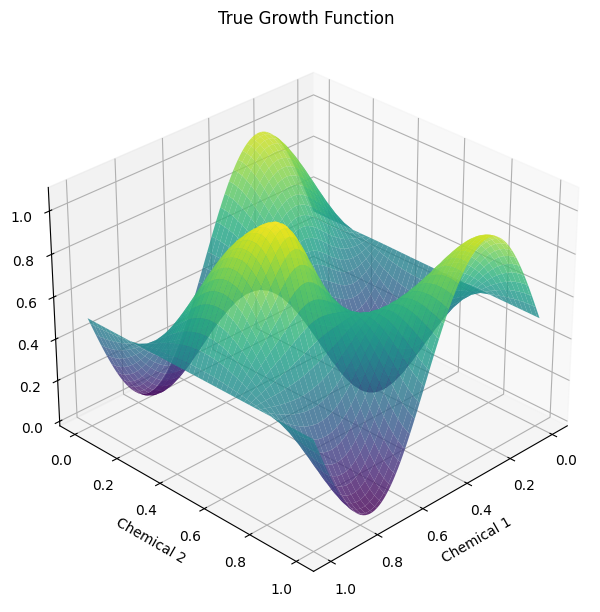

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -----------------------------
# 1. Define True Growth Function (few modest peaks)
# -----------------------------
def true_growth_function_modest_peaks(x1, x2, noise=0.05):
    """
    Fake organism growth with a few modest peaks in the 2D space.
    Peaks are not much higher than the surrounding growth.
    """
    # Base smooth surface
    base = 0.5*np.sin(2*np.pi*x1)*np.cos(2*np.pi*x2) + 0.5
    
    # Add a few modest peaks
    peak1 = 0.2*np.exp(-((x1-0.3)**2 / 0.02 + (x2-0.3)**2 / 0.02))
    peak2 = 0.15*np.exp(-((x1-0.7)**2 / 0.01 + (x2-0.6)**2 / 0.01))
    peak3 = 0.18*np.exp(-((x1-0.5)**2 / 0.03 + (x2-0.8)**2 / 0.03))
    
    # Add small noise
    noise_term = np.random.normal(0, noise)
    
    return base + peak1 + peak2 + peak3 + noise_term


x1_grid = np.linspace(0, 1, 100)
x2_grid = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
Y_true = np.array([[true_growth_function_modest_peaks(x1, x2, noise=0) for x1 in x1_grid] for x2 in x2_grid])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y_true, cmap=cm.viridis, alpha=0.8)
ax.set_xlabel('Chemical 1')
ax.set_ylabel('Chemical 2')
ax.set_zlabel('Growth', rotation=90, labelpad=10)
ax.view_init(elev=30, azim=45)
fig.tight_layout()
plt.title('True Growth Function')
plt.show()

In [12]:

# -----------------------------
# 2. Generate Fake Data
# -----------------------------
np.random.seed(42)
n_samples = 50
X_init = np.random.rand(n_samples, 2)
y_init = np.array([true_growth_function_modest_peaks(x[0], x[1]) for x in X_init])

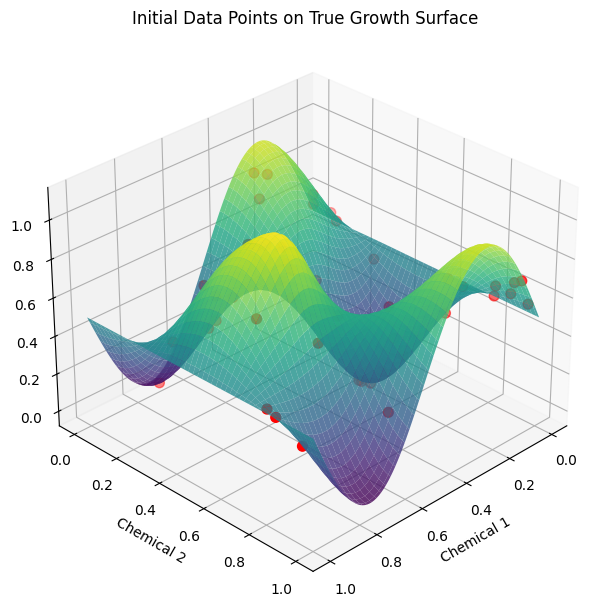

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y_true, cmap=cm.viridis, alpha=0.8)
ax.scatter(X_init[:,0], X_init[:,1],
           [true_growth_function_modest_peaks(x[0], x[1], noise=0) for x in X_init],
           color='red', s=50, label='Start points')
ax.set_xlabel('Chemical 1')
ax.set_ylabel('Chemical 2')
ax.set_zlabel('Growth', rotation=90, labelpad=10)
ax.view_init(elev=30, azim=45)
fig.tight_layout()
plt.title('Initial Data Points on True Growth Surface')
plt.show()

In [21]:
from skopt.space import Real
from skopt.utils import use_named_args
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# -----------------------------
# 3. Define Search Space (2 chemicals)
# -----------------------------
space = [Real(0.0, 1.0, name=f"chem_{i+1}") for i in range(2)]

# -----------------------------
# 4. Train Gaussian Process Surrogate
# -----------------------------
kernel = ConstantKernel(1.0) * Matern(length_scale=0.2, nu=2.5) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X_init, y_init)  # X_init is now 2D

# -----------------------------
# 5. Define Objective for BO
# -----------------------------
@use_named_args(space)
def objective(**params):
    x = np.array([params["chem_1"], params["chem_2"]]).reshape(1, -1)
    pred, _ = gp.predict(x, return_std=True)
    return -float(pred)  # minimize negative predicted growth


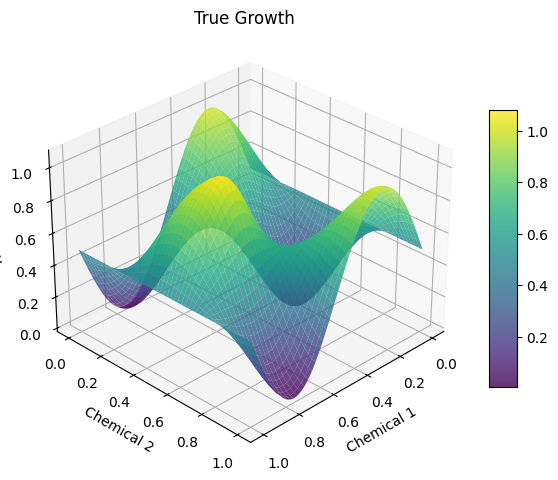

/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/796444279.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/796444279.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/796444279.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred)
/var/folders/9g/q_w246652jsfrgt

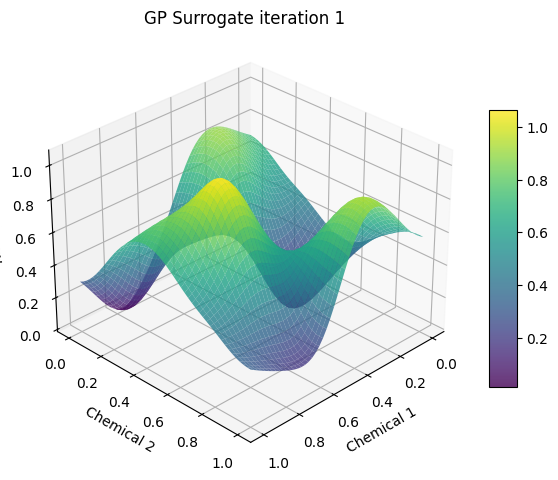

In [25]:
# -----------------------------
# 6. Visualization Utilities (2D version)
# -----------------------------
def plot_surface_2d(func, resolution=50, title=""):
    """
    Plot a 3D surface for a 2D function (two input chemicals).
    func: function that takes a 2D array [[x1, x2]] and returns a scalar.
    """
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X1, X2 = np.meshgrid(x, y)
    Z = np.zeros_like(X1)

    for i in range(resolution):
        for j in range(resolution):
            point = np.array([[X1[i, j], X2[i, j]]])
            Z[i, j] = func(point)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8)
    ax.set_xlabel("Chemical 1")
    ax.set_ylabel("Chemical 2")
    ax.set_zlabel("Growth")
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
    ax.view_init(elev=30, azim=45)
    plt.show()

# -----------------------------
# 7. Helper: GP surrogate prediction
# -----------------------------
def surrogate_prediction(x):
    pred, _ = gp.predict(x, return_std=True)
    return float(pred)

# -----------------------------
# 8. Visualize True Function & Surrogate
# -----------------------------
plot_surface_2d(lambda x: true_growth_function_modest_peaks(x[0,0], x[0,1],noise=0), title="True Growth")
plot_surface_2d(surrogate_prediction, title="GP Surrogate iteration 1")


In [32]:
# -----------------------------
# 8. Run Bayesian Optimization (2D)
# -----------------------------
result = gp_minimize(
    func=objective,
    dimensions=space,        # e.g. space = [(0.0, 1.0), (0.0, 1.0)]
    n_calls=25,
    n_initial_points=5,
    acq_func="EI",
    random_state=42
)

# -----------------------------
# 9. Show Results
# -----------------------------
X_opt = np.array(result.x)
print(f"\nBest found concentrations: chem_1={X_opt[0]:.3f}, chem_2={X_opt[1]:.3f}")
print(f"Predicted maximum growth: {-result.fun:.3f}")


# All tested/suggested points
next_points = np.array(result.x_iters)
next_values = np.array(result.func_vals)

# Show the last 5 points (the most recent suggestions)
print("Next suggested concentrations to test:")
print(next_points[-5:])




/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/2608916845.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # minimize negative predicted growth
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/2608916845.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # minimize negative predicted growth
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/2608916845.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operati


Best found concentrations: chem_1=0.735, chem_2=0.572
Predicted maximum growth: 1.068
Next suggested concentrations to test:
[[0.19794308 1.        ]
 [0.21267308 0.15421294]
 [1.         1.        ]
 [1.         0.3872321 ]
 [0.27730518 0.88458139]]


/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_8970/2608916845.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # minimize negative predicted growth


In [34]:
print(next_points[-5:])

[[0.19794308 1.        ]
 [0.21267308 0.15421294]
 [1.         1.        ]
 [1.         0.3872321 ]
 [0.27730518 0.88458139]]


/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


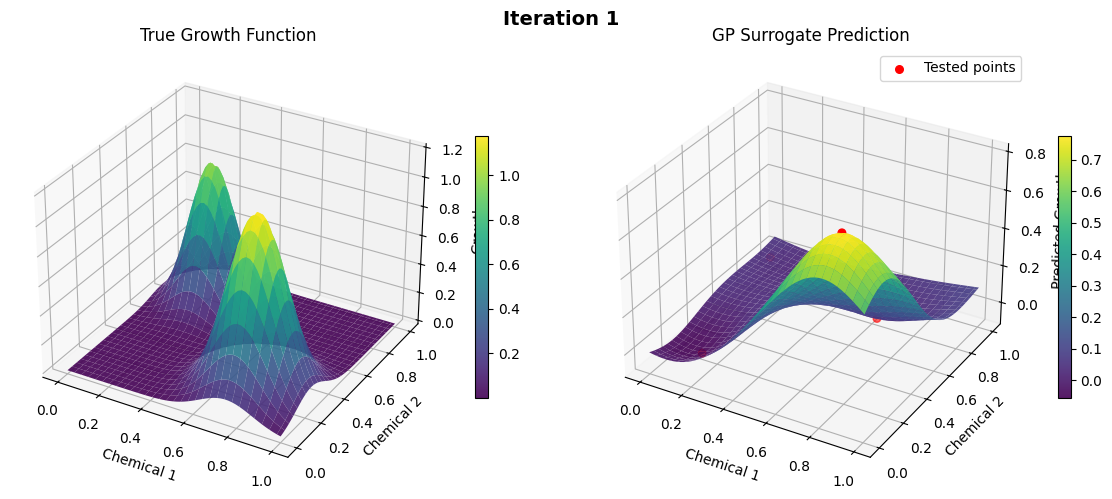

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


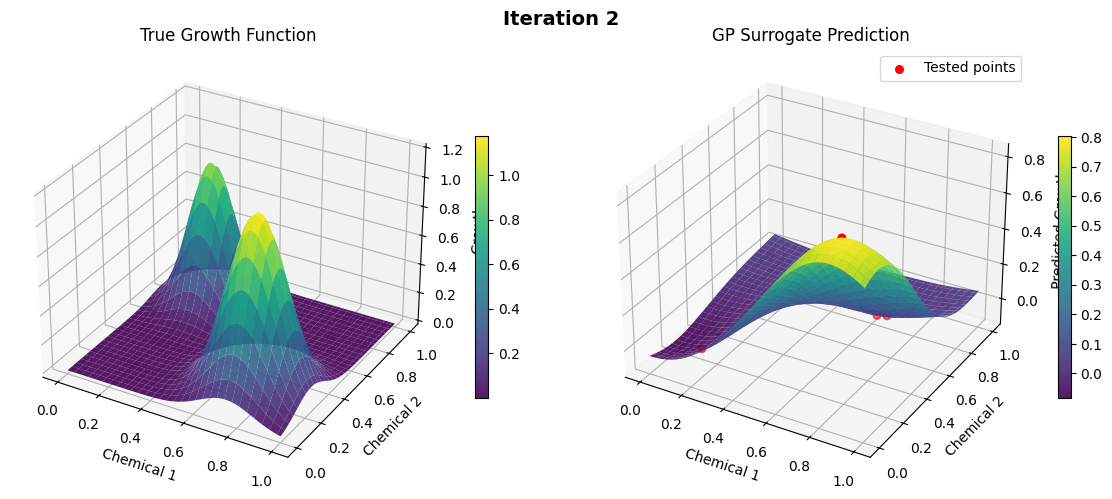

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


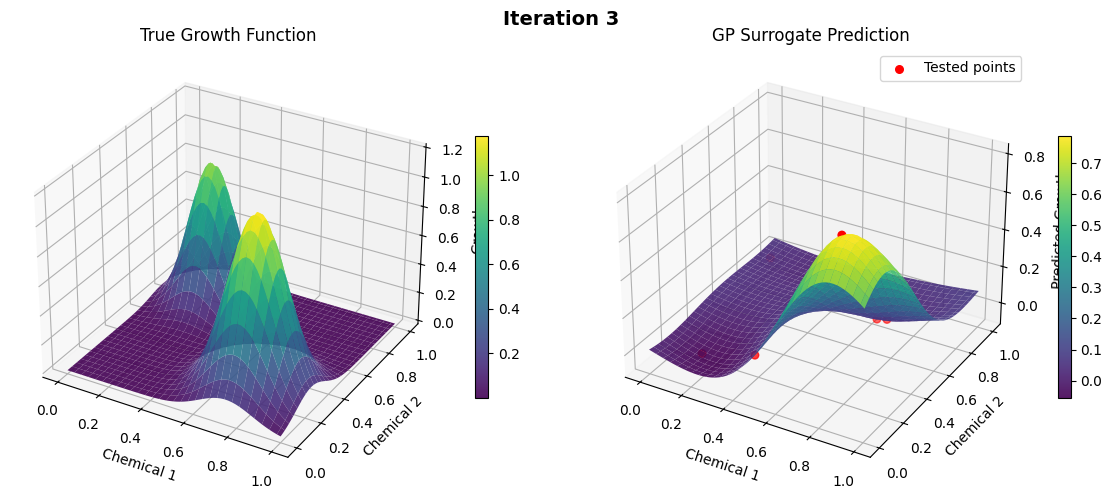

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


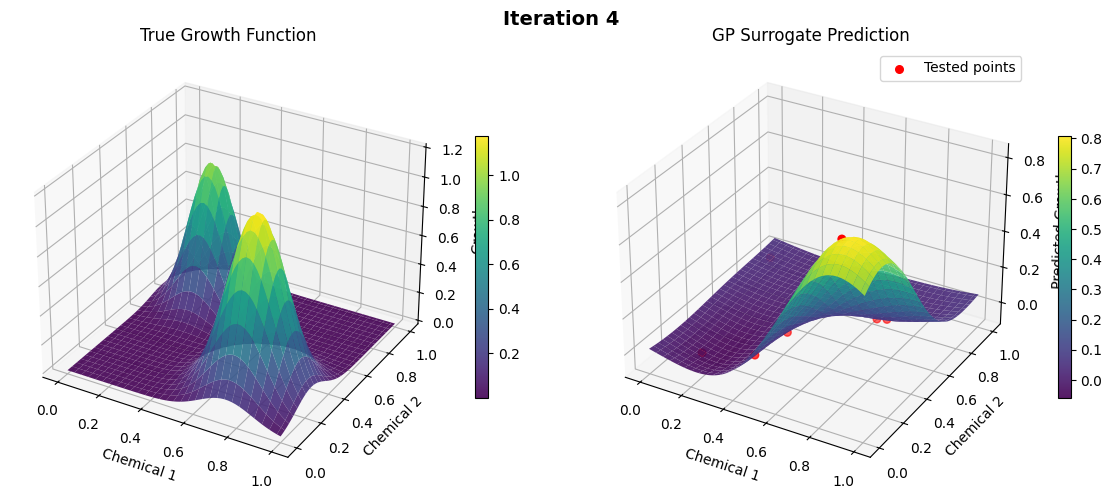

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


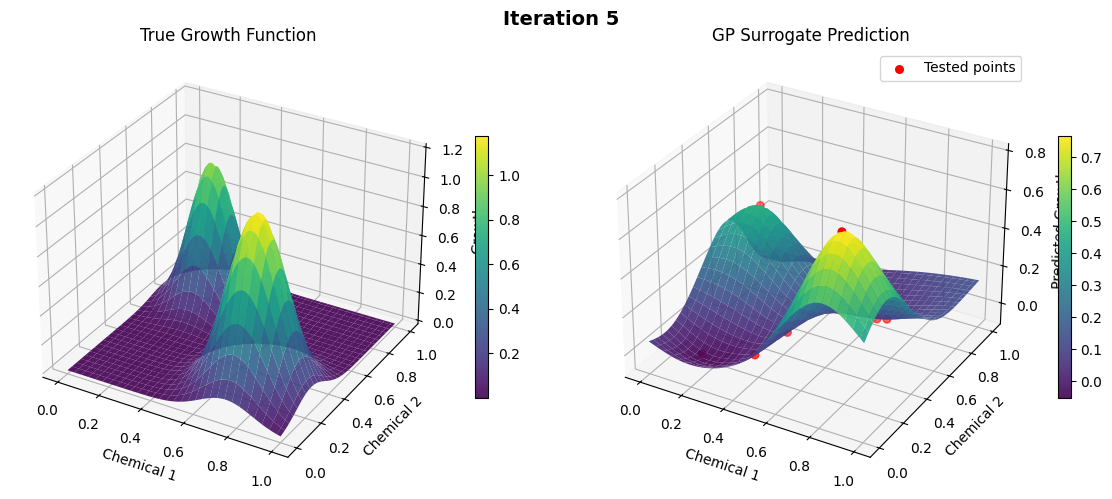

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


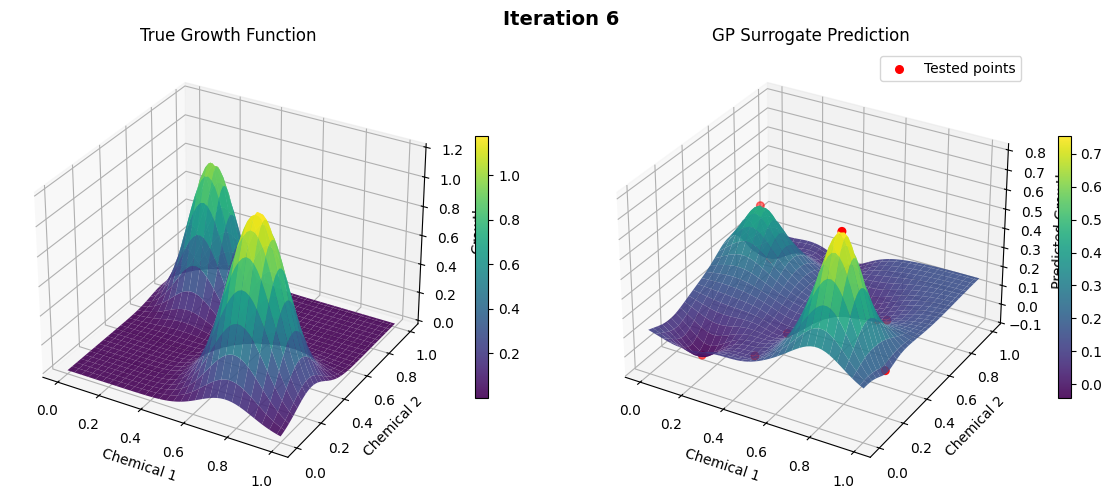

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


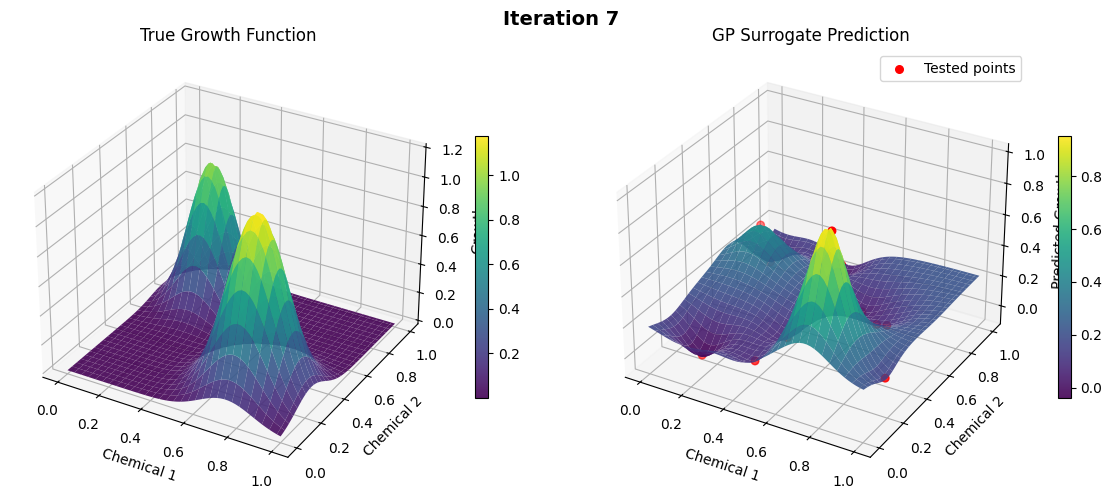

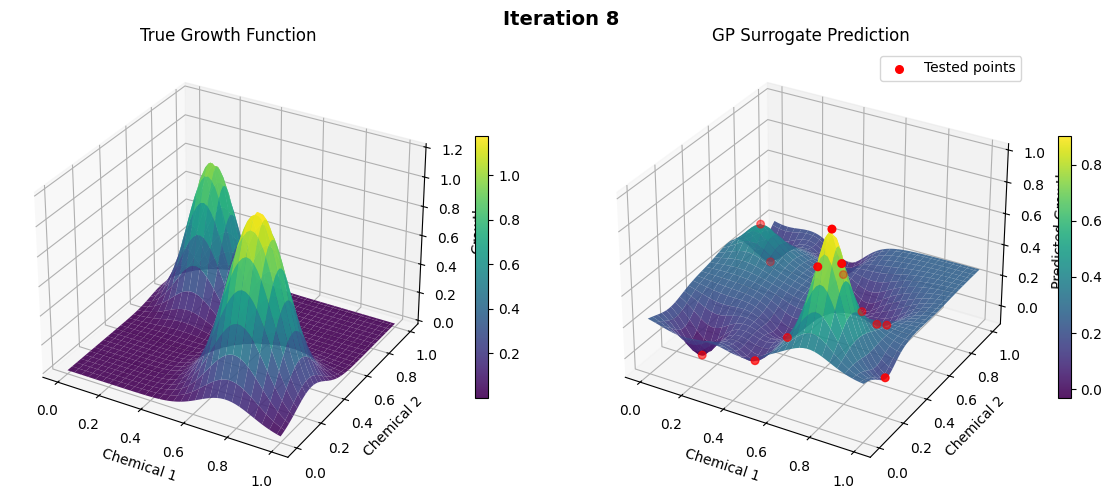

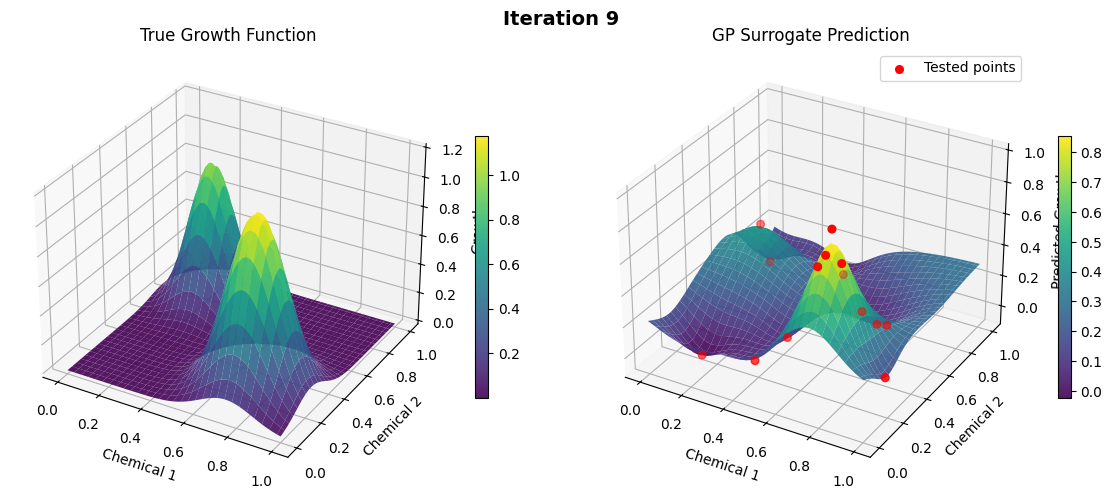

/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


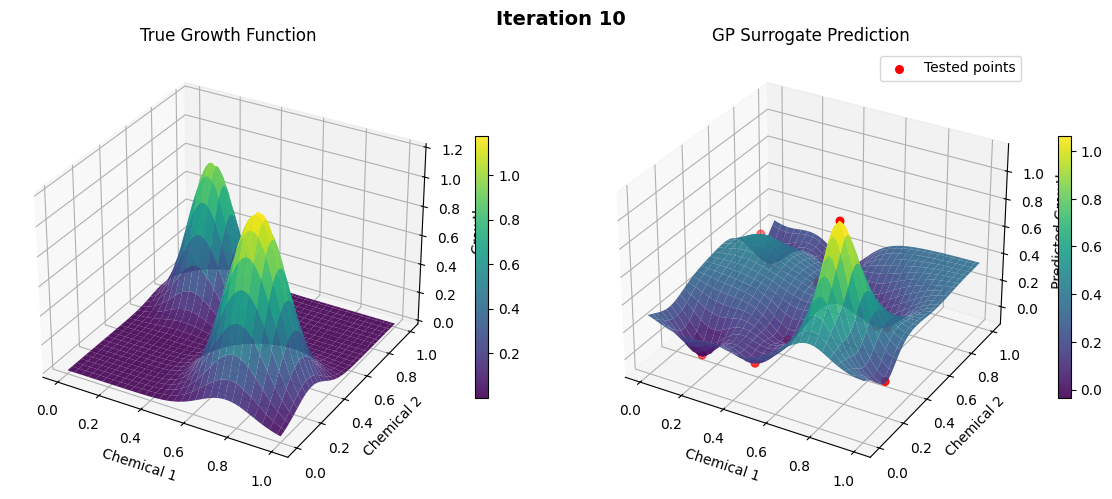


Best found concentrations:
  chem_1 = 0.750
  chem_2 = 0.251
  Observed growth = 1.111


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skopt import Optimizer
from skopt.space import Real
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel

# -----------------------------
# 1. Define True Growth Function (2D)
# -----------------------------
def true_growth_function(chem_1, chem_2, noise=0.1):
    """Fake growth function with 2 peaks + Gaussian noise."""
    peak1 = np.exp(-((chem_1 - 0.25) ** 2 + (chem_2 - 0.75) ** 2) / 0.02)
    peak2 = 1.2 * np.exp(-((chem_1 - 0.75) ** 2 + (chem_2 - 0.25) ** 2) / 0.03)
    return peak1 + peak2 + np.random.normal(0, noise)

# -----------------------------
# 2. Initialize Data
# -----------------------------
np.random.seed(42)
X_init = np.random.rand(5, 2)
y_init = np.array([true_growth_function(x[0], x[1]) for x in X_init])

# -----------------------------
# 3. Define Search Space
# -----------------------------
space = [Real(0.0, 1.0, name="chem_1"),
         Real(0.0, 1.0, name="chem_2")]

# -----------------------------
# 4. Set up Bayesian Optimizer
# -----------------------------
opt = Optimizer(
    dimensions=space,
    acq_func="EI",   # Expected Improvement
    random_state=42
)

# Initialize optimizer with first observations
opt.tell(X_init.tolist(), (-y_init).tolist())

# -----------------------------
# 5. Visualization Function
# -----------------------------
def plot_true_and_surrogate(gp, X_data, y_data, iteration):
    """Plot true growth function vs GP surrogate side by side."""
    x = np.linspace(0, 1, 60)
    y = np.linspace(0, 1, 60)
    X1, X2 = np.meshgrid(x, y)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    # True growth (no noise)
    Y_true = np.array([[true_growth_function(x1, x2, noise=0)
                        for x1 in x] for x2 in y])

    # Surrogate prediction
    Y_pred = gp.predict(X_grid).reshape(X1.shape)

    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(f"Iteration {iteration}", fontsize=14, fontweight="bold")

    # True function
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X1, X2, Y_true, cmap=cm.viridis, alpha=0.9)
    ax1.set_title("True Growth Function")
    ax1.set_xlabel("Chemical 1")
    ax1.set_ylabel("Chemical 2")
    ax1.set_zlabel("Growth")
    fig.colorbar(surf1, ax=ax1, shrink=0.6)

    # GP surrogate
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X1, X2, Y_pred, cmap=cm.viridis, alpha=0.9)
    ax2.scatter(X_data[:, 0], X_data[:, 1], y_data, color="red", s=30, label="Tested points")
    ax2.set_title("GP Surrogate Prediction")
    ax2.set_xlabel("Chemical 1")
    ax2.set_ylabel("Chemical 2")
    ax2.set_zlabel("Predicted Growth")
    ax2.legend()
    fig.colorbar(surf2, ax=ax2, shrink=0.6)

    plt.tight_layout()
    plt.show()

# -----------------------------
# 6. Iterative Optimization Loop
# -----------------------------
n_iterations = 10

X_data = X_init.copy()
y_data = y_init.copy()

for i in range(1, n_iterations + 1):
    # Suggest next candidate
    X_next = np.array(opt.ask()).reshape(1, -1)

    # Evaluate the true function (simulate experiment)
    y_next = true_growth_function(X_next[0, 0], X_next[0, 1])

    # Add to dataset
    X_data = np.vstack([X_data, X_next])
    y_data = np.append(y_data, y_next)

    # Update optimizer with negative growth (since it minimizes)
    opt.tell(X_next.tolist(), [-y_next])

    # Retrain our GP model on all data
    kernel = ConstantKernel(1.0) * Matern(length_scale=0.2, nu=2.5) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
    gp.fit(X_data, y_data)

    # Plot updated surrogate
    plot_true_and_surrogate(gp, X_data, y_data, iteration=i)

# -----------------------------
# 7. Best Found Result
# -----------------------------
best_idx = np.argmax(y_data)
print(f"\nBest found concentrations:")
print(f"  chem_1 = {X_data[best_idx, 0]:.3f}")
print(f"  chem_2 = {X_data[best_idx, 1]:.3f}")
print(f"  Observed growth = {y_data[best_idx]:.3f}")
